In [2]:
import numpy as np
import scipy.special as sp

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import copy
import time
import random

import torch
import torch.nn as nn
import torch.optim as optim
import collections

**Introduce experience replay.**

In [3]:
Transition = collections.namedtuple('Experience',
                                    field_names=['state', 'action',
                                                 'next_state', 'reward',
                                                 'is_game_on'])

class ExperienceReplay:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.memory)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size, device = 'cuda'):
        indices = np.random.choice(len(self.memory), batch_size, replace = False)
        
        states, actions, next_states, rewards, isgameon = zip(*[self.memory[idx] 
                                                                for idx in indices])
        
        return torch.Tensor(states).type(torch.float).to(device), \
               torch.Tensor(actions).type(torch.long).to(device), \
               torch.Tensor(next_states).to(device), \
               torch.Tensor(rewards).to(device), torch.tensor(isgameon).to(device)

**Networks definition.**

In [4]:
class fc_nn(nn.Module):
    def __init__(self, Ni, Nh1, Nh2, No = 4):
        super().__init__()
        
        self.fc1 = nn.Linear(Ni, Nh1)
        self.fc2 = nn.Linear(Nh1, Nh2)
        self.fc3 = nn.Linear(Nh2, No)
        
        self.act = nn.ReLU()
        
    def forward(self, x, classification = False, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        out = self.fc3(x)
        
        return out

In [5]:
# class DuelingDQN(nn.Module):
#     def __init__(self, input_size, hidden_size1, hidden_size2, output_size=4):
#         super().__init__()
        
#         # Feature extractor
#         self.feature_layer = nn.Sequential(
#             nn.Linear(input_size, hidden_size1),
#             nn.ReLU(),
#             nn.Linear(hidden_size1, hidden_size2),
#             nn.ReLU()
#         )
        
#         # Value stream
#         self.value_stream = nn.Sequential(
#             nn.Linear(hidden_size2, hidden_size2 // 2),
#             nn.ReLU(),
#             nn.Linear(hidden_size2 // 2, 1)
#         )
        
#         # Advantage stream
#         self.advantage_stream = nn.Sequential(
#             nn.Linear(hidden_size2, hidden_size2 // 2),
#             nn.ReLU(),
#             nn.Linear(hidden_size2 // 2, output_size)
#         )
    
#     def forward(self, x):
#         features = self.feature_layer(x)
#         value = self.value_stream(features)
#         advantages = self.advantage_stream(features)
        
#         # Combine value and advantages
#         return value + (advantages - advantages.mean(dim=1, keepdim=True))

class DuelingDQN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size=4):
        super().__init__()
        # Feature extractor
        self.feature_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU()
        )
        # Value stream
        self.value_stream = nn.Sequential(
            nn.Linear(hidden_size2, hidden_size2 // 2),
            nn.ReLU(),
            nn.Linear(hidden_size2 // 2, 1)
        )
        # Advantage stream
        self.advantage_stream = nn.Sequential(
            nn.Linear(hidden_size2, hidden_size2 // 2),
            nn.ReLU(),
            nn.Linear(hidden_size2 // 2, output_size)
        )
    
    def forward(self, x):
        # features = self.feature_layer(x)
        # value = self.value_stream(features)
        # advantages = self.advantage_stream(features)
        # # Combine value and advantages
        # return value + (advantages - advantages.mean(dim=1, keepdim=True))
        features = self.feature_layer(x)
        value = self.value_stream(features)
        advantages = self.advantage_stream(features)
        # Ensure proper advantage normalization
        return value + (advantages - advantages.mean(dim=1, keepdim=True))


In [6]:
class conv_nn(nn.Module):
    
    channels = [16, 32, 64]
    kernels = [3, 3, 3]
    strides = [1, 1, 1]
    in_channels = 1
    
    def __init__(self, rows, cols, n_act):
        super().__init__()
        self.rows = rows
        self.cols = cols

        self.conv = nn.Sequential(nn.Conv2d(in_channels = self.in_channels,
                                            out_channels = self.channels[0],
                                            kernel_size = self.kernels[0],
                                            stride = self.strides[0]),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels = self.channels[0],
                                            out_channels = self.channels[1],
                                            kernel_size = self.kernels[1],
                                            stride = self.strides[1]),
                                  nn.ReLU()
                                 )
        
        size_out_conv = self.get_conv_size(rows, cols)
        
        self.linear = nn.Sequential(nn.Linear(size_out_conv, rows*cols*2),
                                    nn.ReLU(),
                                    nn.Linear(rows*cols*2, int(rows*cols/2)),
                                    nn.ReLU(),
                                    nn.Linear(int(rows*cols/2), n_act),
                                   )

    def forward(self, x):
        x = x.view(len(x), self.in_channels, self.rows, self.cols)
        out_conv = self.conv(x).view(len(x),-1)
        out_lin = self.linear(out_conv)
        return out_lin
    
    def get_conv_size(self, x, y):
        out_conv = self.conv(torch.zeros(1,self.in_channels, x, y))
        return int(np.prod(out_conv.size()))

In [7]:
# def Qloss(batch, net, gamma=0.99, device="cuda"):
#     states, actions, next_states, rewards, _ = batch
#     lbatch = len(states)
#     state_action_values = net(states.view(lbatch,-1))
#     state_action_values = state_action_values.gather(1, actions.unsqueeze(-1))
#     state_action_values = state_action_values.squeeze(-1)
    
#     next_state_values = net(next_states.view(lbatch, -1))
#     next_state_values = next_state_values.max(1)[0]
    
#     next_state_values = next_state_values.detach()
#     expected_state_action_values = next_state_values * gamma + rewards
    
#     return nn.MSELoss()(state_action_values, expected_state_action_values)

# def huber_loss(x, delta=1.0):
#     return torch.where(
#         torch.abs(x) < delta,
#         0.5 * x**2,
#         delta * (torch.abs(x) - 0.5 * delta)
#     )


# def improved_qloss(batch, online_net, target_net, gamma=0.99, device="cuda"):
#     states, actions, next_states, rewards, is_game_on = batch
#     lbatch = len(states)
    
#     # Get current Q values
#     state_action_values = online_net(states.view(lbatch, -1))
#     state_action_values = state_action_values.gather(1, actions.unsqueeze(-1)).squeeze(-1)
    
#     # Get next state values from target network
#     with torch.no_grad():
#         # Double DQN: select action using online network
#         next_actions = online_net(next_states.view(lbatch, -1)).max(1)[1]
#         # Evaluate action using target network
#         next_state_values = target_net(next_states.view(lbatch, -1))
#         next_state_values = next_state_values.gather(1, next_actions.unsqueeze(-1)).squeeze(-1)
        
#         # Mask for terminal states
#         next_state_values = next_state_values * is_game_on.float()
        
#         # Calculate expected Q values
#         expected_state_action_values = rewards + gamma * next_state_values
    
#     # Use Huber loss
#     return huber_loss(state_action_values - expected_state_action_values).mean()
#     # return nn.MSELoss()(state_action_values, expected_state_action_values)

def huber_loss(x, delta=1.0):
    return torch.where(
        torch.abs(x) < delta,
        0.5 * x**2,
        delta * (torch.abs(x) - 0.5 * delta)
    )

def improved_qloss(batch, online_net, target_net, gamma=0.99, device="cuda", step_penalty=0.01):
    states, actions, next_states, rewards, is_game_on = batch
    lbatch = len(states)
    
    # Subtract a small penalty per step (applied to every reward)
    rewards = rewards - step_penalty

    # Get current Q values
    state_action_values = online_net(states.view(lbatch, -1))
    state_action_values = state_action_values.gather(1, actions.unsqueeze(-1)).squeeze(-1)
    
    # Get next state values using Double DQN scheme
    with torch.no_grad():
        next_actions = online_net(next_states.view(lbatch, -1)).max(1)[1]
        next_state_values = target_net(next_states.view(lbatch, -1))
        next_state_values = next_state_values.gather(1, next_actions.unsqueeze(-1)).squeeze(-1)
        next_state_values = next_state_values * is_game_on.float()
        expected_state_action_values = rewards + gamma * next_state_values
    
    return huber_loss(state_action_values - expected_state_action_values).mean()
    # return nn.MSELoss()(state_action_values, expected_state_action_values)

**Import the maze and define the environment.**

In [8]:
from environment import MazeEnvironment

maze = np.load('maze_generator/maze.npy')

initial_position = [0,0]
goal = [len(maze)-1, len(maze)-1]

maze_env = MazeEnvironment(maze, initial_position, goal)

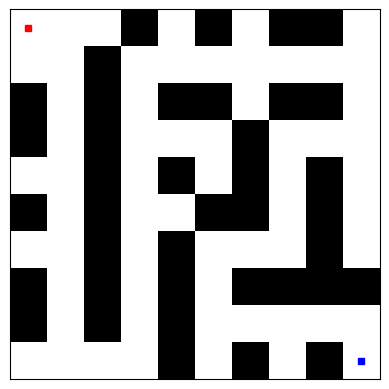

In [9]:
maze_env.draw('maze_20.pdf')

**Define the agent and the buffer for experience replay.**

In [10]:
buffer_capacity = 10000
buffer_start_size = 1000
memory_buffer = ExperienceReplay(buffer_capacity)

In [11]:
from agent import Agent
agent = Agent(maze = maze_env,
              memory_buffer = memory_buffer,
              use_softmax = True
             )

** Define the network.**

In [12]:
# net = fc_nn(maze.size, maze.size, maze.size, 4)
online_net = DuelingDQN(maze.size, maze.size*2, maze.size*2, 4)
target_net = DuelingDQN(maze.size, maze.size*2, maze.size*2, 4)
target_net.load_state_dict(online_net.state_dict())
target_net.eval() 

optimizer = optim.Adam(online_net.parameters(), lr=0.00025)

In [13]:
device = 'cuda'
batch_size = 32
# batch_size = 64
gamma = 0.99
target_update_freq = 100

# net.to(device)
online_net.to(device)
target_net.to(device)


DuelingDQN(
  (feature_layer): Sequential(
    (0): Linear(in_features=100, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
  )
  (value_stream): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
  (advantage_stream): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=4, bias=True)
  )
)

**Define the epsilon profile and plot the resetting probability.**

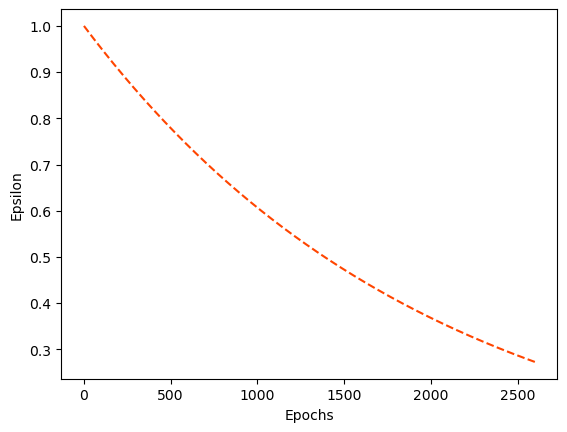

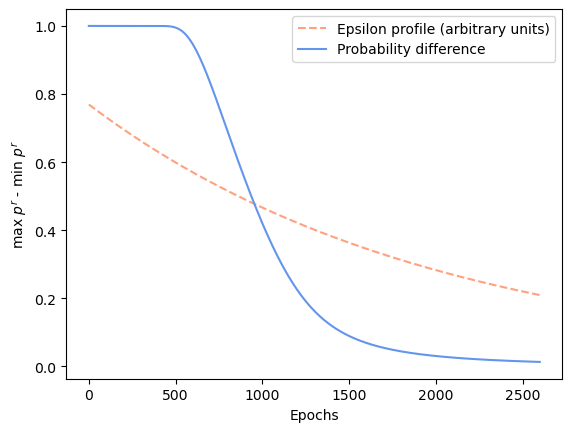

In [14]:
num_epochs = 2600

cutoff = 2000
epsilon = np.exp(-np.arange(num_epochs)/(cutoff))
# print(epsilon)
# epsilon[epsilon > epsilon[100*int(num_epochs/cutoff)]] = epsilon[100*int(num_epochs/cutoff)]
min_epsilon = 0.05
epsilon = np.maximum(epsilon, min_epsilon)

plt.plot(epsilon, color = 'orangered', ls = '--')
plt.xlabel('Epochs')
plt.ylabel('Epsilon')
plt.savefig('epsilon_profile.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

mp = []
mpm = []
reg = 200
for e in epsilon:
    a = agent.env.reset_policy(e)
    mp.append(np.min(a))
    mpm.append(np.max(a))

plt.plot(epsilon/1.3, color = 'orangered', ls = '--', alpha = 0.5,
         label= 'Epsilon profile (arbitrary units)')

plt.plot(np.array(mpm)-np.array(mp), label = 'Probability difference', color = 'cornflowerblue')
plt.xlabel('Epochs')
plt.ylabel(r'max $p^r$ - min $p^r$')
plt.legend()
plt.savefig('reset_policy.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

**Training the network.**

In [ ]:
# loss_log = []
# best_loss = 1e5

# running_loss = 0

# for epoch in range(num_epochs):
#     loss = 0
#     counter = 0
#     eps = epsilon[epoch]
    
#     agent.isgameon = True
#     _ = agent.env.reset(eps)
    
#     while agent.isgameon:
#         agent.make_a_move(net, eps)
#         counter += 1
        
#         if len(agent.buffer) < buffer_start_size:
#             continue
            
#         optimizer.zero_grad()
#         batch = agent.buffer.sample(batch_size, device = device)
#         # print(f"length of batch is {len(batch)}")
#         states, actions, next_states, rewards, _ = batch
#         # print(f"this is the state ({len(states[0])} x {len(states[0][0])}): {states[0]}")
#         # print(f"these are the actions ({len(actions)}): {actions}")
#         # print(f"these are the next states ({len(next_states[0])} x {len(next_states[0][0])}): {next_states[0]}")
#         # print(f"the rewards ({len(rewards)} x {len(rewards)}) are {rewards}")
        
#         loss_t = Qloss(batch, net, gamma = gamma, device = device)
#         loss_t.backward()
#         optimizer.step()
        
#         loss += loss_t.item()
    
#     if (agent.env.current_position == agent.env.goal).all():
#         result = 'won'
#     else:
#         result = 'lost'
    
#     if epoch%1000 == 0:
#         agent.plot_policy_map(net, 'sol_epoch_'+str(epoch)+'.pdf', [0.35,-0.3])
    
#     loss_log.append(loss)
    
#     if (epoch > 2000):
#         running_loss = np.mean(loss_log[-50:])
#         if running_loss < best_loss:
#             best_loss = running_loss
#             torch.save(net.state_dict(), "best.torch")
#             estop = epoch
    
#     print('Epoch', epoch, '(number of moves ' + str(counter) + ')')
#     print('Game', result)
#     print('[' + '#'*(100-int(100*(1 - epoch/num_epochs))) +
#           ' '*int(100*(1 - epoch/num_epochs)) + ']')
#     print('\t Average loss: ' + f'{loss:.5f}')
#     if (epoch > 2000):
#         print('\t Best average loss of the last 50 epochs: ' + f'{best_loss:.5f}' + ', achieved at epoch', estop)
#     clear_output(wait = True)

# loss_log = []
# best_loss = 1e5

# running_loss = 0

# for epoch in range(num_epochs):
#     loss = 0
#     counter = 0
#     eps = epsilon[epoch]

#     agent.isgameon = True
#     _ = agent.env.reset(eps)

#     while agent.isgameon:
#         agent.make_a_move(online_net, eps)
#         counter += 1

#         if len(agent.buffer) < buffer_start_size:
#             continue

#         optimizer.zero_grad()
#         batch = agent.buffer.sample(batch_size, device = device)
        
#         # Use improved loss function with online and target networks
#         loss_t = improved_qloss(batch, online_net, target_net, gamma = gamma, device = device)
#         loss_t.backward()
#         optimizer.step()

#         loss += loss_t.item()

#     # Update target network periodically
#     if epoch % target_update_freq == 0:
#         target_net.load_state_dict(online_net.state_dict())

#     if (agent.env.current_position == agent.env.goal).all():
#         result = 'won'
#     else:
#         result = 'lost'

#     if epoch%1000 == 0:
#         agent.plot_policy_map(online_net, 'sol_epoch_'+str(epoch)+'.pdf', [0.35,-0.3])

#     loss_log.append(loss)

#     if (epoch > 2000):
#         running_loss = np.mean(loss_log[-50:])
#         if running_loss < best_loss:
#             best_loss = running_loss
#             torch.save(online_net.state_dict(), "best.torch")
#             estop = epoch

#     print('Epoch', epoch, '(number of moves ' + str(counter) + ')')
#     print('Game', result)
#     print('[' + '#'*(100-int(100*(1 - epoch/num_epochs))) +
#           ' '*int(100*(1 - epoch/num_epochs)) + ']')
#     print('\t Average loss: ' + f'{loss:.5f}')
#     if (epoch > 2000):
#         print('\t Best average loss of the last 50 epochs: ' + f'{best_loss:.5f}' + ', achieved at epoch', estop)
#     clear_output(wait = True)

loss_log = []
best_loss = 1e5
running_loss = 0
max_steps_per_episode = 500  # New maximum step count

for epoch in range(num_epochs):
    loss = 0
    counter = 0
    eps = epsilon[epoch]
    
    agent.isgameon = True
    _ = agent.env.reset(eps)
    
    while agent.isgameon:
        agent.make_a_move(online_net, eps)
        counter += 1
        
        # Terminate if max steps reached
        if counter >= max_steps_per_episode:
            agent.isgameon = False
            break
        
        if len(agent.buffer) < buffer_start_size:
            continue
        
        optimizer.zero_grad()
        batch = agent.buffer.sample(batch_size, device=device)
        
        loss_t = improved_qloss(batch, online_net, target_net, gamma=gamma, device=device, step_penalty=0.0001)
        loss_t.backward()
        optimizer.step()
        
        loss += loss_t.item()
    
    # Update target network periodically
    if epoch % target_update_freq == 0:
        target_net.load_state_dict(online_net.state_dict())
    
    if (agent.env.current_position == agent.env.goal).all():
        result = 'won'
    else:
        result = 'lost'
    
    print(f'Epoch {epoch}, Moves: {counter}, Result: {result}')
    loss_log.append(loss)
    
    # Save best model based on average loss
    if epoch > 2000:
        running_loss = np.mean(loss_log[-50:])
        if running_loss < best_loss:
            best_loss = running_loss
            torch.save(online_net.state_dict(), "best.torch")
            estop = epoch

    print('Epoch', epoch, '(number of moves ' + str(counter) + ')')
    print('Game', result)
    progress = '#' * (100 - int(100 * (1 - epoch/num_epochs)))
    spaces = ' ' * int(100 * (1 - epoch/num_epochs))
    print('[' + progress + spaces + ']')
    print('\t Average loss: ' + f'{loss:.5f}')
    clear_output(wait=True)

# for epoch in range(num_epochs):
#     loss = 0
#     counter = 0
#     eps = epsilon[epoch]

#     agent.isgameon = True
#     _ = agent.env.reset(eps)

#     while agent.isgameon:
#         agent.make_a_move(online_net, eps)
#         counter += 1
        
#         # Force termination if too many steps have been taken in one episode.
#         # if counter >= max_steps_per_episode:
#         #     agent.isgameon = False
#         #     break

#         if counter >= max_steps_per_episode:
#             print(f"Epoch {epoch}: Episode terminated at max step limit ({max_steps_per_episode}).")
#             agent.isgameon = False
#             break
    
#         if (agent.env.current_position == agent.env.goal).all():
#             print(f"Epoch {epoch}: Goal reached in {counter} moves.")

#         if len(agent.buffer) < buffer_start_size:
#             continue

#         optimizer.zero_grad()
#         batch = agent.buffer.sample(batch_size, device=device)
        
#         # Use improved loss function with a step penalty
#         loss_t = improved_qloss(batch, online_net, target_net, gamma=gamma, device=device, step_penalty=0.0001)
#         loss_t.backward()
#         optimizer.step()

#         loss += loss_t.item()

#     # Periodically update the target network
#     if epoch % target_update_freq == 0:
#         target_net.load_state_dict(online_net.state_dict())

#     if (agent.env.current_position == agent.env.goal).all():
#         result = 'won'
#     else:
#         result = 'lost'

#     if epoch % 1000 == 0:
#         agent.plot_policy_map(online_net, 'sol_epoch_' + str(epoch) + '.pdf', [0.35, -0.3])

#     loss_log.append(loss)

#     if epoch > 2000:
#         running_loss = np.mean(loss_log[-50:])
#         if running_loss < best_loss:
#             best_loss = running_loss
#             torch.save(online_net.state_dict(), "best.torch")
#             estop = epoch

#     print('Epoch', epoch, '(number of moves ' + str(counter) + ')')
#     print('Game', result)
#     progress = '#' * (100 - int(100 * (1 - epoch/num_epochs)))
#     spaces = ' ' * int(100 * (1 - epoch/num_epochs))
#     print('[' + progress + spaces + ']')
#     print('\t Average loss: ' + f'{loss:.5f}')
#     if epoch > 2000:
#         print('\t Best average loss of the last 50 epochs: ' + f'{best_loss:.5f}' + ', achieved at epoch', estop)
#     clear_output(wait=True)

Epoch 1944, Moves: 66, Result: won
Epoch 1944 (number of moves 66)
Game won
[###########################################################################                         ]
	 Average loss: 0.07026


In [ ]:
# torch.save(net.state_dict(), "net.torch")
torch.save(online_net.state_dict(), "net.torch")

In [ ]:
plt.plot(epsilon*90, alpha = 0.6, ls = '--', label = 'Epsilon profile (arbitrary unit)', color = 'orangered')
plt.plot((np.array(mpm)-np.array(mp))*120, alpha = 0.6, ls = '--',
         label = 'Probability difference (arbitrary unit)', color = 'dimgray')
plt.plot(loss_log, label = 'Loss', color = 'cornflowerblue')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.savefig('loss.pdf', dpi = 300, bbox_inches='tight')
plt.show()

**Show the maze solution and the policy learnt.**

In [ ]:
# net.eval()
# agent.isgameon = True
# agent.use_softmax = False
# _ = agent.env.reset(0)
# while agent.isgameon:
#     agent.make_a_move(net, 0)
#     agent.env.draw('')
#     clear_output(wait = True)

online_net.eval()
agent.isgameon = True
agent.use_softmax = False
_ = agent.env.reset(0)
while agent.isgameon:
    agent.make_a_move(online_net, 0)
    agent.env.draw('')    
    clear_output(wait = True)

In [ ]:
# agent.plot_policy_map(net, 'solution.pdf', [0.35,-0.3])
agent.plot_policy_map(online_net, 'solution.pdf', [0.35,-0.3])

In [ ]:
best_net = copy.deepcopy(online_net)
best_net.load_state_dict(torch.load('net.torch'))

In [ ]:
agent.plot_policy_map(best_net, 'solution_best.pdf', [0.35,-0.3])